In [1]:
import geopandas as gpd
import numpy as np
from shapely.ops import nearest_points
import folium
import pandas as pd

# --- 1. Load cadastre and roads ---
cadastre = gpd.read_file("cadastre.gpkg")
roads = gpd.read_file("roads.gpkg")

# --- 2. Reproject to projected CRS (meters) ---
projected_crs = "EPSG:7856"  # adjust as needed
cadastre = cadastre.to_crs(projected_crs)
roads = roads.to_crs(projected_crs)

# --- 3. Find nearest road ---
cadastre_nearest = gpd.sjoin_nearest(
    cadastre,
    roads,
    how="left",
    distance_col="dist_to_road"
)

# Add nearest road geometry
cadastre_nearest["geometry_road"] = roads.loc[cadastre_nearest["index_right"]].geometry.values

# --- 4. Compute road azimuth ---
def line_azimuth(line):
    if line.geom_type == 'LineString' and len(line.coords) >= 2:
        x1, y1 = line.coords[0]
        x2, y2 = line.coords[-1]
        dx = x2 - x1
        dy = y2 - y1
        az = np.degrees(np.arctan2(dx, dy))
        return (az + 360) % 360
    return np.nan

roads["azimuth"] = roads.geometry.apply(line_azimuth)

# --- 5. Compute parcel facing azimuth toward nearest road ---
def parcel_facing(parcel_geom, road_geom):
    c = parcel_geom.centroid
    nearest_pt = nearest_points(c, road_geom)[1]
    dx = nearest_pt.x - c.x
    dy = nearest_pt.y - c.y
    az = np.degrees(np.arctan2(dx, dy))
    return (az + 360) % 360

cadastre_nearest["facing_azimuth"] = cadastre_nearest.apply(
    lambda row: parcel_facing(row.geometry, row.geometry_road), axis=1
)

# --- 6. Convert azimuth to cardinal orientation ---
def azimuth_to_cardinal(az):
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    idx = int((az + 22.5) // 45) % 8
    return dirs[idx]

cadastre_nearest["orientation"] = cadastre_nearest["facing_azimuth"].apply(azimuth_to_cardinal)

df =pd.read_parquet("gnaf_prop.parquet")
gnaf_df =gpd.GeoDataFrame(df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326"
)


gnaf_df.to_crs(projected_crs)
print(gnaf_df.columns)
property_with_orientation = gpd.sjoin_nearest(
    gnaf_df,                       # left: properties
    cadastre_nearest[['geometry_road', 'orientation', 'geometry']],  # right: roads
    how='left',
    distance_col='dist_to_road'
).copy()[['address','geometry','orientation']]
print(property_with_orientation)


# --- Save to CSV ---
# Convert geometry to WKT for CSV
property_with_orientation['geometry_wkt'] = property_with_orientation['geometry'].apply(lambda g: g.wkt if g else None)
property_with_orientation[['address', 'orientation',]].to_csv("property_with_orientation.csv", index=False)

# --- Save to GeoPackage ---
# Ensure geometry column is set
property_with_orientation_gdf = property_with_orientation.set_geometry('geometry')[['address', 'orientation','geometry']]
property_with_orientation_gdf.to_file("property_with_orientation.gpkg", layer='properties', driver="GPKG")

# --- 7. Prepare for interactive map ---
# Reproject to WGS84 for Folium
cadastre_plot = cadastre_nearest.to_crs(epsg=4326)
roads_plot = roads.to_crs(epsg=4326)
cadastre_plot['centroid'] = cadastre_plot.geometry.centroid

# Color mapping for orientations
orientation_colors = {
    'N': 'red', 'NE': 'orange', 'E': 'yellow', 'SE': 'green',
    'S': 'blue', 'SW': 'purple', 'W': 'brown', 'NW': 'pink'
}

# Map center
map_center = [cadastre_plot['centroid'].y.mean(), cadastre_plot['centroid'].x.mean()]
m = folium.Map(location=map_center, zoom_start=16, tiles=None)

# Base layers
folium.TileLayer('OpenStreetMap', name='Street Map', attr='© OpenStreetMap contributors').add_to(m)
folium.TileLayer(
    tiles='https://stamen-tiles.a.ssl.fastly.net/terrain/{z}/{x}/{y}.jpg',
    name='Terrain Map',
    attr='Map tiles by Stamen Design, © OpenStreetMap contributors',
    max_zoom=18
).add_to(m)

# Add roads
for _, row in roads_plot.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda f: {'color': 'black', 'weight': 1, 'opacity': 0.5},
        name='Roads'
    ).add_to(m)

# Add cadastre parcels as CircleMarkers using centroids
for _, row in cadastre_plot.iterrows():
    folium.CircleMarker(
        location=[row['centroid'].y, row['centroid'].x],
        radius=5,
        color=orientation_colors.get(row['orientation'], 'gray'),
        fill=True,
        fill_color=orientation_colors.get(row['orientation'], 'gray'),
        fill_opacity=0.7,
        popup=f"Orientation: {row['orientation']}"
    ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 120px; height: 250px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
     <b>Orientation</b><br>
"""
for o, c in orientation_colors.items():
    legend_html += f'<i style="background:{c};width:10px;height:10px;display:inline-block;margin-right:5px;"></i>{o}<br>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Layer control
folium.LayerControl().add_to(m)

m


Index(['gid', 'gnaf_pid', 'street_locality_pid', 'locality_pid',
       'alias_principal', 'primary_secondary', 'building_name', 'lot_number',
       'flat_number', 'level_number', 'number_first', 'number_last',
       'street_name', 'street_type', 'street_suffix', 'address',
       'locality_name', 'postcode', 'state', 'locality_postcode', 'confidence',
       'legal_parcel_id', 'mb_2016_code', 'mb_2021_code', 'latitude',
       'longitude', 'geocode_type', 'reliability', 'geom', 'schema',
       'geometry'],
      dtype='object')


/var/folders/5l/4gfdgm4927n2gx3mj9g81_4r0000gs/T/ipykernel_78081/4199151675.py:70: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:7856

  property_with_orientation = gpd.sjoin_nearest(
/Users/sd277/.pyenv/versions/3.10.16/envs/streamlit_dashboard/lib/python3.10/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


                   address                     geometry orientation
0       10 MELNOTTE AVENUE   POINT (151.1826 -33.78748)          NE
0       10 MELNOTTE AVENUE   POINT (151.1826 -33.78748)          NE
0       10 MELNOTTE AVENUE   POINT (151.1826 -33.78748)          NE
1       11 MELNOTTE AVENUE  POINT (151.18321 -33.78716)          NE
1       11 MELNOTTE AVENUE  POINT (151.18321 -33.78716)          NE
...                    ...                          ...         ...
17673  1 ROSEBRIDGE AVENUE  POINT (151.20407 -33.78006)          NE
17673  1 ROSEBRIDGE AVENUE  POINT (151.20407 -33.78006)          NE
17674     7 GLENROY AVENUE  POINT (151.20852 -33.79106)          NE
17674     7 GLENROY AVENUE  POINT (151.20852 -33.79106)          NE
17674     7 GLENROY AVENUE  POINT (151.20852 -33.79106)          NE

[211773 rows x 3 columns]


/var/folders/5l/4gfdgm4927n2gx3mj9g81_4r0000gs/T/ipykernel_78081/4199151675.py:93: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cadastre_plot['centroid'] = cadastre_plot.geometry.centroid


In [2]:
# load required modules
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely import wkt



In [3]:


# --- Load cadastre and roads files---
cadastre = gpd.read_file("cadastre.gpkg")
roads = gpd.read_file("roads.gpkg")

# --- Step 1: Reproject to projected CRS (meters) ---
projected_crs = "EPSG:7856"  # GDA2020 MGA zone; adjust if needed
cadastre = cadastre.to_crs(projected_crs)
roads = roads.to_crs(projected_crs)

# --- Step 2: sjoin_nearest ---
cadastre_nearest = gpd.sjoin_nearest(
    cadastre,
    roads,                 # include only geometry if no other cols
    how="left",
    distance_col="dist_to_road"
)

# Inspect columns
print(cadastre_nearest.columns)

# The nearest road geometry is now in 'geometry_right' only if roads had additional cols.
# If roads only had 'geometry', then cadastre_nearest['geometry'] = parcel geometry.
# In that case, we manually extract nearest road geometry using index_right:
cadastre_nearest["geometry_road"] = roads.loc[cadastre_nearest["index_right"]].geometry.values
print(cadastre_nearest.columns)


Index(['state', 'sa4', 'geometry', 'index_right', 'osm_id', 'code', 'fclass',
       'name', 'layer', 'bridge', 'tunnel', 'fname', 'type', 'width',
       'population', 'ref', 'oneway', 'maxspeed', 'dist_to_road'],
      dtype='object')
Index(['state', 'sa4', 'geometry', 'index_right', 'osm_id', 'code', 'fclass',
       'name', 'layer', 'bridge', 'tunnel', 'fname', 'type', 'width',
       'population', 'ref', 'oneway', 'maxspeed', 'dist_to_road',
       'geometry_road'],
      dtype='object')


In [4]:
#--compute azimuthal angle--#
def line_azimuth(line):
    if line is None or line.is_empty:
        return np.nan
    if line.geom_type.startswith("Multi"):
        line = list(line.geoms)[0]
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[-1]
    angle = np.degrees(np.arctan2((x2 - x1), (y2 - y1)))
    return (angle + 360) % 360

cadastre_nearest["azimuth"] = cadastre_nearest["geometry_road"].apply(line_azimuth)
print(cadastre_nearest["azimuth"])

0       189.534618
0       343.443162
1       343.443162
2        72.321502
3        72.321502
           ...    
1289     81.120186
1290     81.120186
1291     81.120186
1292     81.120186
1293     81.120186
Name: azimuth, Length: 1473, dtype: float64


In [5]:
#-- convert azimutal to cardinal angle----#
def azimuth_to_cardinal(angle):
    if pd.isna(angle):
        return None
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ix = int((angle + 22.5) // 45) % 8
    return dirs[ix]

cadastre_nearest["orientation"] = cadastre_nearest["azimuth"].apply(azimuth_to_cardinal)
cadastre_nearest["orientation"]


0       S
0       N
1       N
2       E
3       E
       ..
1289    E
1290    E
1291    E
1292    E
1293    E
Name: orientation, Length: 1473, dtype: object

In [6]:

# Load properties with pandas
gnaf_df = pd.read_parquet("gnaf_prop.parquet")

# Identify geometry in GNAF
# Example: if GNAF has lon/lat columns
if {"longitude", "latitude"}.issubset(gnaf_df.columns):
    gnaf = gpd.GeoDataFrame(
        gnaf_df,
        geometry=gpd.points_from_xy(gnaf_df["longitude"], gnaf_df["latitude"]),
        crs="EPSG:4326"
    )
elif "geometry" in gnaf_df.columns:
    gnaf = gpd.GeoDataFrame(
        gnaf_df,
        geometry=gnaf_df["geometry"].apply(wkt.loads),
        crs="EPSG:4326"
    )
else:
    raise ValueError("Cannot find geometry in GNAF dataset")
gnaf = gnaf.to_crs(projected_crs)

# Keep only geometry and address in GNAF
gnaf_for_join = gnaf[['address', 'geometry']].copy()

# Reset index to avoid conflicts
gnaf_for_join = gnaf_for_join.reset_index(drop=True)

# Perform nearest join
cadastre_nearest =cadastre_nearest.rename({'index_right':'rt_idx'}, axis=1)
print(cadastre_nearest.head())
cadastre_with_address = gpd.sjoin_nearest(
    cadastre_nearest,
    gnaf_for_join,
    how='left',
    distance_col='dist_to_address'
)



  state                                sa4  \
0   NSW  Sydney - North Sydney and Hornsby   
0   NSW  Sydney - North Sydney and Hornsby   
1   NSW  Sydney - North Sydney and Hornsby   
2   NSW  Sydney - North Sydney and Hornsby   
3   NSW  Sydney - North Sydney and Hornsby   

                                            geometry  rt_idx      osm_id  \
0  MULTIPOLYGON (((334341.254 6259167.939, 334393...      19   507890154   
0  MULTIPOLYGON (((334341.254 6259167.939, 334393...       4  1081035341   
1  MULTIPOLYGON (((334357.587 6259229.986, 334384...       4  1081035341   
2  MULTIPOLYGON (((334386.743 6259103.77, 334449....       3   507890155   
3  MULTIPOLYGON (((334408.411 6259070.466, 334420...       3   507890155   

   code   fclass                         name  layer bridge  ...  type width  \
0  5154     path                         None    0.0      F  ...  None  None   
0  5154     path  Harold Reid Foreshore Track    0.0      F  ...  None  None   
1  5154     path  Harold R

In [7]:
# ------------------------
# Step 6: Prepare output
# ------------------------

# # Keep only relevant columns
# output = cadastre_with_address[['address', 'orientation', 'geometry']]

# # Ensure one row per property (unique by geometry or address)
# # Option 1: Unique by geometry
# output = output.drop_duplicates(subset=['geometry'])

# # Option 2: Unique by address (if address is unique per property)
# # output = output.drop_duplicates(subset=['address'])

# # Drop any rows with missing values
# output = output.dropna(subset=['address', 'orientation'])

# # Save CSV
# output[['address', 'orientation']].to_csv("property_orientations.csv", index=False)

# # Save GeoPackage (optional)
# output.to_file(
#     "property_orientations.gpkg",
#     layer="property_orientation",
#     driver="GPKG"
# )

# print("✅ Finished: property_orientations.csv and property_orientations.gpkg created with one property per row")


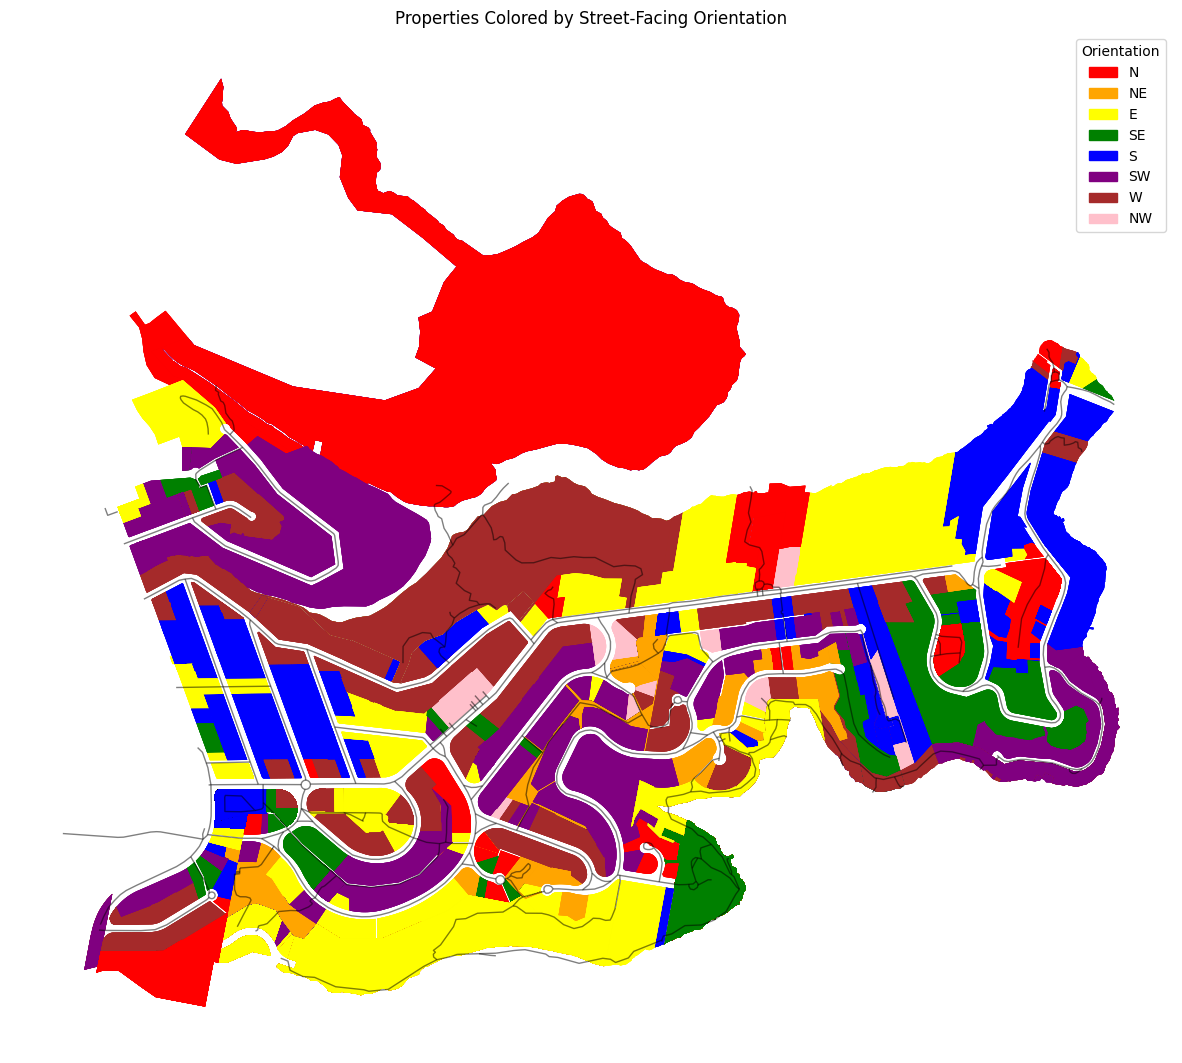

In [8]:
import matplotlib.pyplot as plt

# Reproject to web mercator for plotting
cadastre_plot = cadastre_with_address.to_crs(epsg=3857)
roads_plot = roads.to_crs(epsg=3857)

# Define colors for each orientation
orientation_colors = {
    'N': 'red',
    'NE': 'orange',
    'E': 'yellow',
    'SE': 'green',
    'S': 'blue',
    'SW': 'purple',
    'W': 'brown',
    'NW': 'pink'
}

# Map colors to property points
cadastre_plot['color'] = cadastre_plot['orientation'].map(orientation_colors)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot roads as black lines
roads_plot.plot(ax=ax, color='black', linewidth=1, alpha=0.5)

# Plot properties as points colored by orientation
cadastre_plot.plot(ax=ax, color=cadastre_plot['color'], markersize=10)

# Add legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=c, label=o) for o, c in orientation_colors.items()]
plt.legend(handles=handles, title="Orientation")

plt.title("Properties Colored by Street-Facing Orientation")
plt.axis('off')
plt.show()


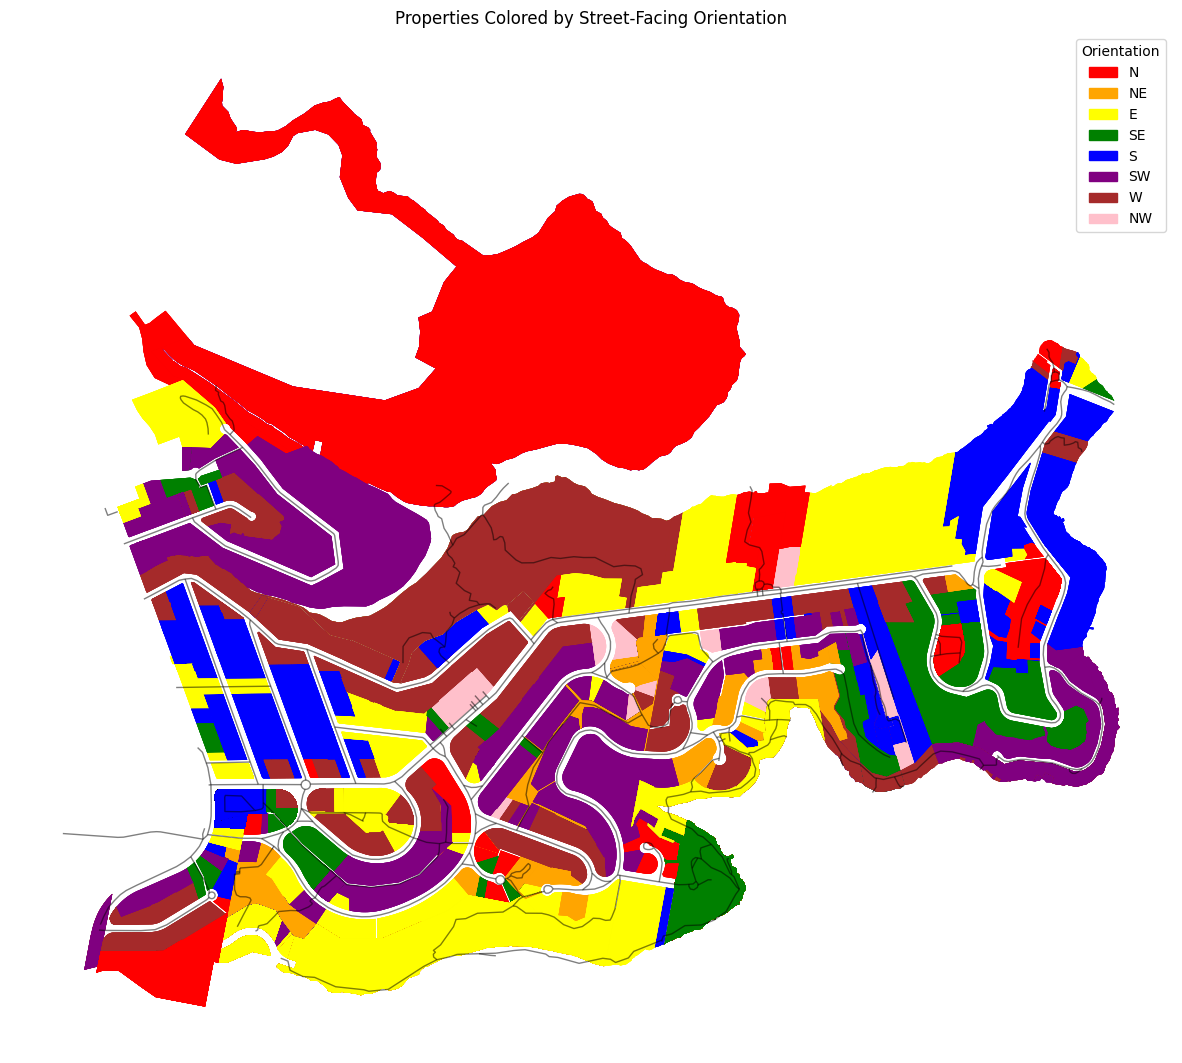

In [9]:
import matplotlib.pyplot as plt

# Reproject to web mercator for plotting
cadastre_plot = cadastre_with_address.to_crs(epsg=3857)
roads_plot = roads.to_crs(epsg=3857)

# Define colors for each orientation
orientation_colors = {
    'N': 'red',
    'NE': 'orange',
    'E': 'yellow',
    'SE': 'green',
    'S': 'blue',
    'SW': 'purple',
    'W': 'brown',
    'NW': 'pink'
}

# Map colors to property points
cadastre_plot['color'] = cadastre_plot['orientation'].map(orientation_colors)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot roads as black lines
roads_plot.plot(ax=ax, color='black', linewidth=1, alpha=0.5)

# Plot properties as points colored by orientation
cadastre_plot.plot(ax=ax, color=cadastre_plot['color'], markersize=10)

# Add legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=c, label=o) for o, c in orientation_colors.items()]
plt.legend(handles=handles, title="Orientation")

plt.title("Properties Colored by Street-Facing Orientation")
plt.axis('off')
plt.show()
